# ABDOMINAL PAIN/PROBLEMS

# Read data from database and build a line chart

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb
import pandas as pd
import itertools
import statsmodels.api as sm
from datetime import datetime
from calendar import monthrange
import math
import warnings
warnings.filterwarnings("ignore")
def getData(county):
    county=county
    conn = MySQLdb.connect(host="localhost", user="i501fa18_group7", passwd="rEm9z3dRGW11", db="i501fa18_group7")
    cursor = conn.cursor()
    if(county == 'all'):
        condition = 'SIT_PROVIDER_PRIM_IMPRESSION= \'Abdominal Pain/Problems\''
    else:
        condition = 'inc_county = \'%s\' and SIT_PROVIDER_PRIM_IMPRESSION = \'Abdominal Pain/Problems\' ' % (county)


    str1="select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_abdom_calls from i501fa18_group7.emergency_medical_service_runs_2014 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str2="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_abdom_calls from i501fa18_group7.emergency_medical_service_runs_2015 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str3="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH , count(INC_INCIDENTID) as Numn_of_abdom_calls from i501fa18_group7.emergency_medical_service_runs_2016 Where %s group by LAST_DAY(INC_INCIDENTDATE)"
    str4="union select LAST_DAY(INC_INCIDENTDATE) as INCIDENT_MTH, count(INC_INCIDENTID) as Numn_of_abdom_calls from i501fa18_group7.emergency_medical_service_runs_2017 Where %s and LAST_DAY(INC_INCIDENTDATE) < \'2017-08-31\' group by LAST_DAY(INC_INCIDENTDATE)"


    query = str1%(condition) + str2%(condition)+ str3%(condition)+ str4%(condition)
    cursor.execute(query);
    rows = cursor.fetchall() 
    months = []
    abdom_calls = []
    for i in rows:
        months.append(datetime.combine(i[0],datetime.min.time()))
        abdom_calls.append(i[1])
    my_data = pd.DataFrame(
        {'Months': months,
         'abdom_Calls': abdom_calls
        })
    my_data = my_data.set_index('Months')
    return my_data;

def decomposeData(my_data):
    check_seasonal = sm.tsa.seasonal_decompose(my_data, model='multiplicative')
    fig = check_seasonal.plot()
    plt.title('Seasonal trending of the Abdominal Pain/Problems Calls Data')
    plt.show()
abdom_pain_calls = getData('all');
print("Properties of the data are :" , abdom_pain_calls.describe())
abdom_pain_calls.plot(figsize=(15,6))
plt.title('Abdominal Pain/Problems calls by month')
plt.show()

Properties of the data are :        abdom_Calls
count    43.000000
mean   2821.069767
std     410.198001
min    1722.000000
25%    2540.500000
50%    2917.000000
75%    3109.500000
max    3427.000000


<Figure size 1500x600 with 1 Axes>

# Seasonal decompose of the data

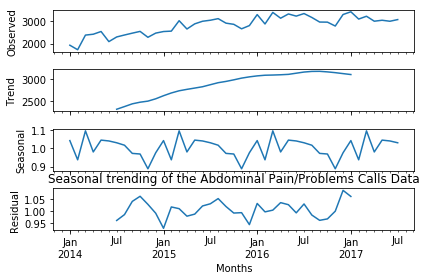

In [3]:
decomposeData(abdom_pain_calls)


# Train the ARIMAX model for data from 2014 to 2016

In [4]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

min_aic = 1000
min_param = ()
min_param_seasonal = ()

train_data = abdom_pain_calls[:2016]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            train_mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = train_mod.fit()
            if (results.aic <= min_aic):
                min_aic = results.aic
                min_param = param
                min_param_seasonal = param_seasonal
            
        except:
            continue

print('minimum AIC in observed at ', min_param, min_param_seasonal, min_aic)          

minimum AIC in observed at  (1, 1, 0) (1, 1, 0, 12) 226.65602080818672


# Build ARIMAX model using the parameters for minimum AIC

In [5]:
mod = sm.tsa.statespace.SARIMAX(abdom_pain_calls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

for i in range(3):
    print(results.summary().tables[i])

                                 Statespace Model Results                                 
Dep. Variable:                        abdom_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -110.328
Date:                            Sat, 15 Dec 2018   AIC                            226.656
Time:                                    20:01:34   BIC                            229.156
Sample:                                01-31-2014   HQIC                           226.904
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0500      0.610     -0.082      0.935      -1.246       1.146
ar.S.L12      -0.3609      0.565   

# Check diagnostics to make sure the model doesn't produce incorrect results

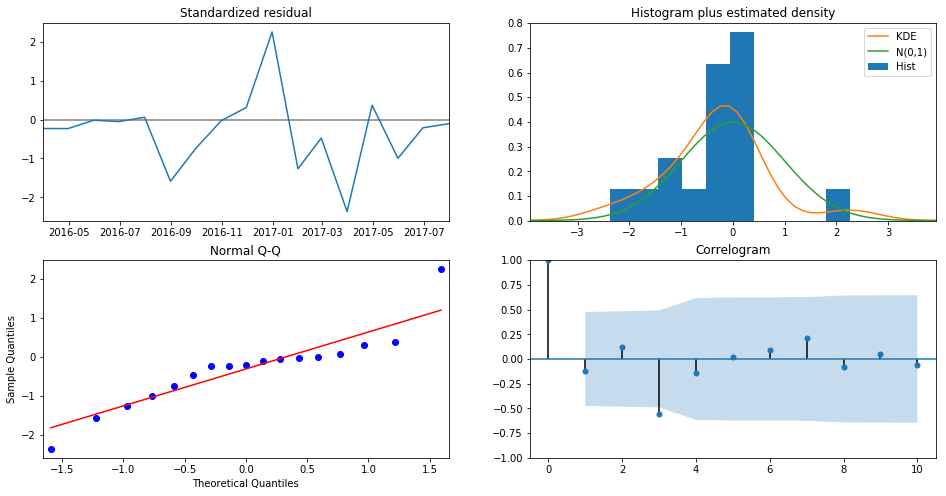

In [6]:
results.plot_diagnostics(figsize=(16,8))
plt.show()

# Predicting the values for 2017 based on training data

                                 Statespace Model Results                                 
Dep. Variable:                        abdom_Calls   No. Observations:                   43
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -110.328
Date:                            Sat, 15 Dec 2018   AIC                            226.656
Time:                                    20:01:35   BIC                            229.156
Sample:                                01-31-2014   HQIC                           226.904
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0500      0.610     -0.082      0.935      -1.246       1.146
ar.S.L12      -0.3609      0.565   

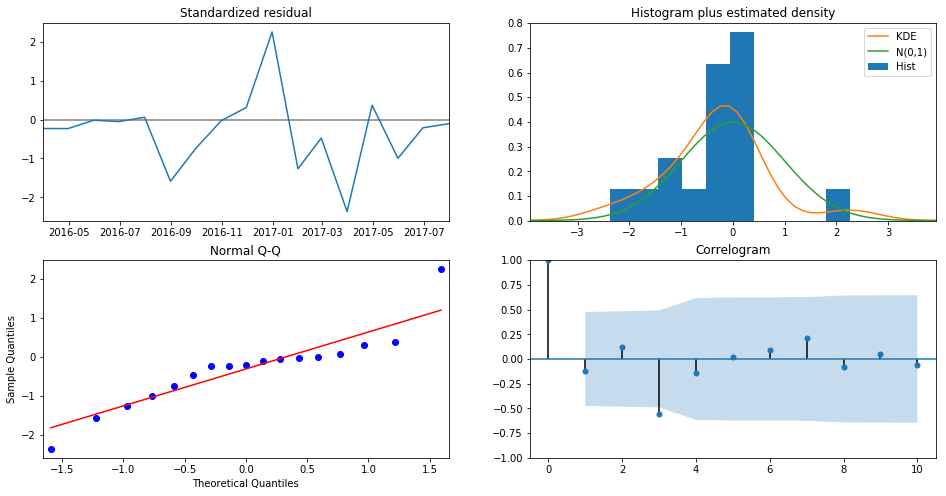

            lower abdom_Calls  upper abdom_Calls
2017-01-31        3316.179851        3940.720817
2017-02-28        2863.145783        3487.686749
2017-03-31        3291.905665        3916.446631
2017-04-30        2632.643543        3257.184509
2017-05-31        2893.277180        3517.818146
2017-06-30        2723.091473        3347.632439
2017-07-31        2781.087310        3405.628276


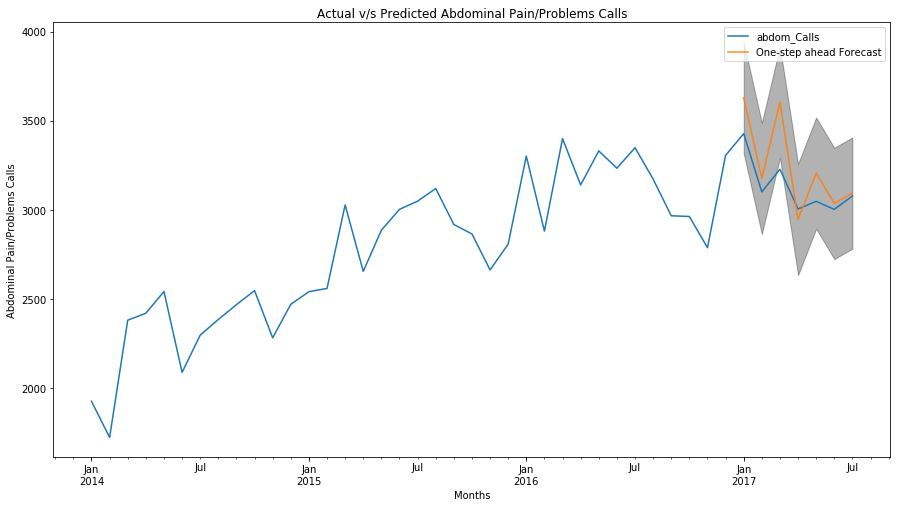

In [7]:
def forecastABDOM(in_data):
    mod = sm.tsa.statespace.SARIMAX(abdom_pain_calls, 
                                order= min_param,
                                seasonal_order= min_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()

    for i in range(3):
        print(results.summary().tables[i])
        
    results.plot_diagnostics(figsize=(16,8))
    plt.show()
   
    pred = results.get_prediction(start=pd.to_datetime('2017-01-31'), dynamic=False)
    pred_ci = pred.conf_int() 
    ax = in_data['2014':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(15, 8))
    print(pred_ci)
    ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.3)
    ax.set_xlabel('Months')
    ax.set_ylabel('Abdominal Pain/Problems Calls')
    plt.legend()
    plt.title('Actual v/s Predicted Abdominal Pain/Problems Calls')
    plt.show()
    
forecastABDOM(abdom_pain_calls)